<a href="https://colab.research.google.com/github/stanleycai95/recommender_project/blob/master/fastai_tweet_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# https://www.kaggle.com/datasets/kazanova/sentiment140 TWITTER SENTIMENT ANALYSIS DATASET

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/"))

# Any results you write to the current directory are saved as output.

['.config', 'sample_data']


In [3]:
from fastai.text import *


In [6]:
full = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='latin-1')

full = full.sample(frac=0.25)
full.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

full.sort_values(by='date', inplace=True)
train = full.iloc[:-100000,:]
test = full.iloc[-100000:,:]
#train = train[0:1000]
# train['Sentiment'] = train['Sentiment'].apply(str)

In [7]:
train.head()

,target,id,date,flag,user,text
8584,0,1548276360,Fri Apr 17 20:30:47 PDT 2009,NO_QUERY,customcanvasart,@USEOFFORCEENT so sorry for your loss honey I...
8591,0,1548277792,Fri Apr 17 20:31:04 PDT 2009,NO_QUERY,leabella,Actually I had 503 maybe I should put my web...
8593,0,1548277960,Fri Apr 17 20:31:05 PDT 2009,NO_QUERY,AnitaKoch,"@lkhalladay Colorado's a beautiful state, but ..."
8596,0,1548278352,Fri Apr 17 20:31:08 PDT 2009,NO_QUERY,torilovesbradie,@charlii1 haha. He's he'll player/ladies man t...
8601,0,1548279034,Fri Apr 17 20:31:12 PDT 2009,NO_QUERY,sanamhatesyou,sexi boi u so fly wish i could give u a try bu...


In [8]:
test.head()

,target,id,date,flag,user,text
1202990,4,1985965484,Sun May 31 18:06:23 PDT 2009,NO_QUERY,BrookieeeW,Loves Andy Samberg
1202996,4,1985965596,Sun May 31 18:06:23 PDT 2009,NO_QUERY,excusemeofficer,@mileycyrus Mileyy good luck! i'm sure you'll ...
1203004,4,1985966007,Sun May 31 18:06:26 PDT 2009,NO_QUERY,shamamillaytea,There he is. Robert pattinson. Looking better ...
1203009,4,1985966176,Sun May 31 18:06:27 PDT 2009,NO_QUERY,tokyotopia,Hey everyone @ShaneSakata and I had an exciti...
261653,0,1985966373,Sun May 31 18:06:28 PDT 2009,NO_QUERY,bluejune18,need to do my hw


In [9]:
test_id = test['id']

In [10]:
test['text'].iloc[0]

'Loves Andy Samberg '

In [11]:
train['target'].unique()

array([0, 4])

In [12]:
data = (TextList.from_df(train, cols='text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


idx,text
0,"xxbos xxunk sorry babes . xxmaj wanna message me and tell meh what 's wrong ? ? xxbos xxunk xxmaj of course i 'm excited too ! xxmaj pictures ! xxmaj you know me ! xxup lol xxmaj john has to work though so it 's a bummer xxrep 4 . xxbos xxmaj is heading to bed after a long day of meetings , sushi and wine ! xxmaj plus"
1,"appreciate it . i got you on myspace later . xxup surprise xxbos xxmaj time to get the night started .. hopefully it ends well xxbos working on xxunk xxbos xxunk xxmaj welcome to the team ... for every team member added , the level of shenanigans seems to rise . xxmaj ca n't wait . xxbos @agentbooth xxmaj yes she did , there 's proof . xxmaj you two"
2,". xxmaj go xxmaj rays ! ! ! xxbos i might be bipolar fuck my life forreal i m over this shit xxbos it 's not xxrep 5 . i am very disappointed xxbos xxmaj does not miss caffeine , but does miss his flavored coffee . xxbos xxmaj both movies tonight were pretty bad lol they were the two i said i was nt going to watch too ."
3,"xxmaj google xxmaj toolbar for xxmaj chrome ? :| i no xxunk this xxbos xxunk xxunk : xxmaj it 's sold out xxbos xxmaj wish i was feeling better already xxbos it is not allowed to rain . xxbos xxunk i hope you guys do n't have too good a time . xxbos xxmaj thinks your sweet but i stil feel ill , x x xxbos bunch of work to"
4,"industry is xxunk xxbos xxup rip xxmaj dennis xxunk - he fought a xxunk fight xxunk chronic , progressive xxup ms for over 20 years . xxmaj you 'll be missed , xxmaj denny ! xxbos xxunk xxmaj would xxunk be an option ? xxmaj otherwise xxmaj dan says first gathering will be going over this stuff . xxmaj what 's the conflict for xxmaj sat ? xxbos @ xxunk"


In [13]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)


In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


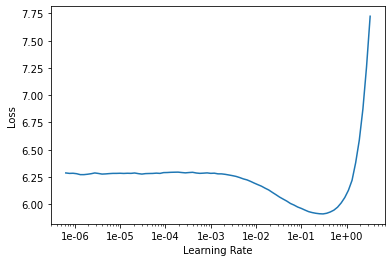

In [15]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,4.517951,4.364958,0.233954,15:05


In [ ]:
 # Tune a little more
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save_encoder('fine_tuned_enc')

In [ ]:
test_datalist = TextList.from_df(test, cols='text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'target')
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

In [ ]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()


In [ ]:
learn_classifier.lr_find()


In [ ]:
learn_classifier.recorder.plot()

In [ ]:
learn_classifier.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))


In [ ]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))


In [ ]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn_classifier.show_results()


In [ ]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)


In [ ]:
submission = pd.DataFrame({'id': test_id, 'target': labels})
submission.to_csv('submission.csv', index=False)
submission.head()